# Objectron Tutorial: Grabbing samples from shareded TF.record files.

This notebook provide an example on how to grab a few rows from the sharded tf.record files. We will be using the `tf.data.TFRecordDataset` for reading the datasets. For more information checkout [TFRecord and tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file).

In [39]:
dataset_dir = '.../chair_test-*'
NUM_PARALLEL_CALLS = 4
WIDTH = 480
HEIGHT = 640
NUM_CHANNELS = 3
# The 3D bounding box has 9 vertices, 0: is the center, and the 8 vertices of the 3D box.
NUM_KEYPOINTS = 9
BATCH_SIZE = 4

In [40]:
import glob
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from objectron.schema import features
from objectron.dataset import box
from objectron.dataset import graphics

Implementing a typical image pipeline in Tensorflow/Jax.

In [41]:
def parse(example):
  """Parses a single tf.Example and decode the `png` string to an array."""
  data = tf.io.parse_single_example(example, features = features.FEATURE_MAP)
  data['image'] = tf.image.decode_png(data[features.FEATURE_NAMES['IMAGE_ENCODED']], channels=NUM_CHANNELS)
  data['image'].set_shape([HEIGHT, WIDTH, NUM_CHANNELS])
  return data 

def augment(data):
  return data

def normalize(data):
  """Convert `image` from [0, 255] -> [-1., 1.] floats."""
  data['image'] = tf.cast(data['image'], tf.float32) * (2. / 255.) - 1.0  
  return data

def load_tf_record(input_record):
  dataset = tf.data.TFRecordDataset(input_record)

  dataset = dataset.map(parse, num_parallel_calls = NUM_PARALLEL_CALLS)\
                   .map(augment, num_parallel_calls = NUM_PARALLEL_CALLS)\
                   .map(normalize, num_parallel_calls = NUM_PARALLEL_CALLS)
  # Our TF.records are shuffled in advance. If you re-generate the dataset from the video files, you'll need to
  # shuffle your examples. Keep in mind that you cannot shuffle the entire datasets using dataset.shuffle, since 
  # it will be very slow.
  dataset = dataset.shuffle(100)\
                   .repeat()\
                   .batch(BATCH_SIZE)\
                   .prefetch(buffer_size=10)
  return dataset


dataset = load_tf_record(glob.glob(dataset_dir))

Grabbing a few row from the dataset and visualizing the 3D bounding boxes. 
The Objectron features are defined in `/schema/features.py`. In this example, we only used the 2D keypoints but each sample contains alot more information, such as 3D keypoints, the object name, pose information, etc.

This code uses dataset/graphics.py for visualizing the 3D bounding box on the image.

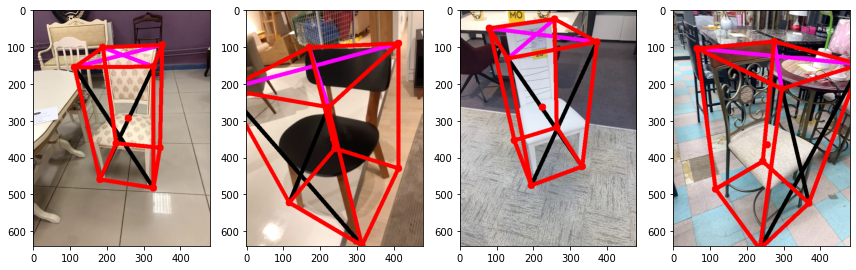

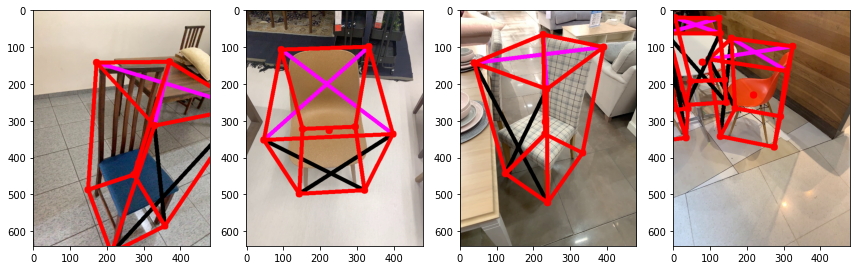

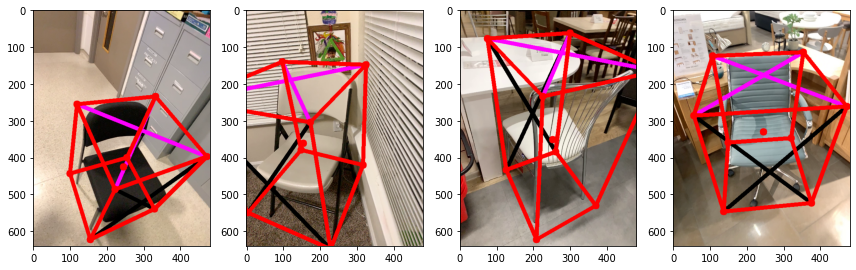

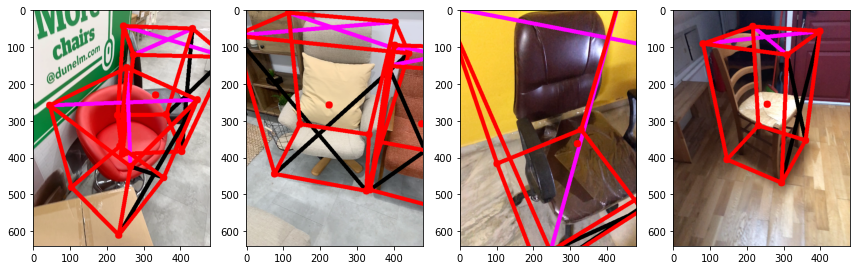

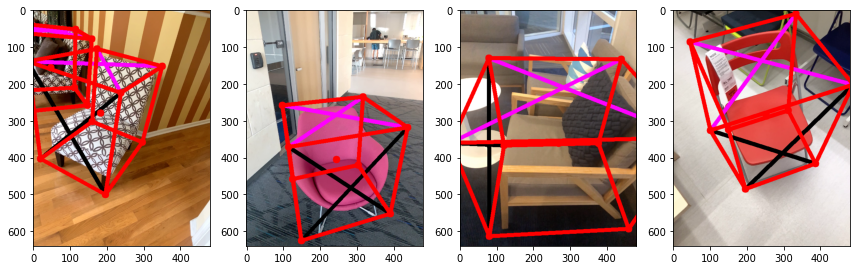

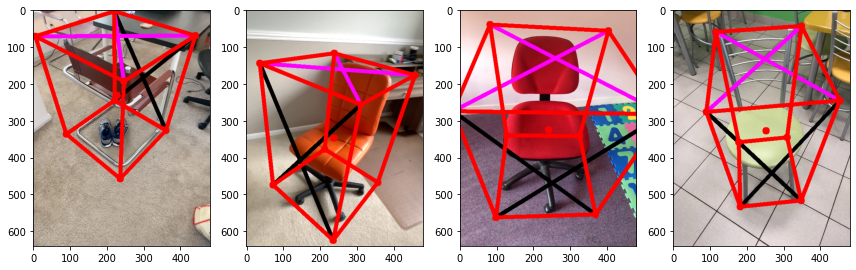

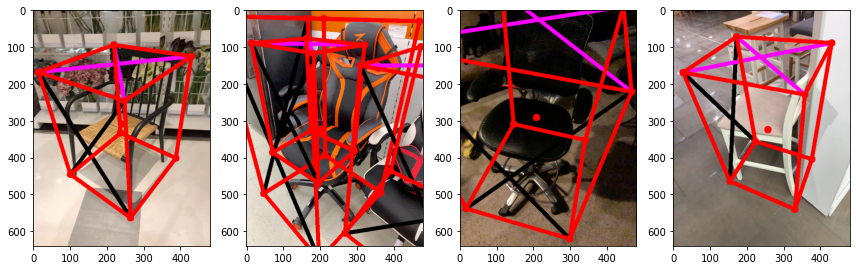

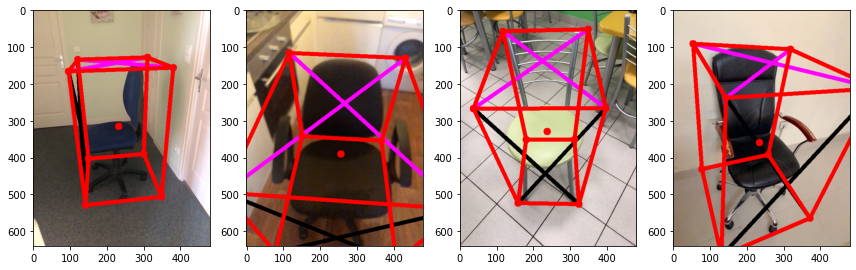

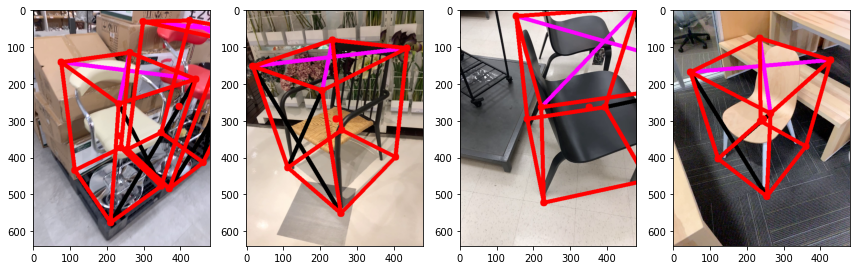

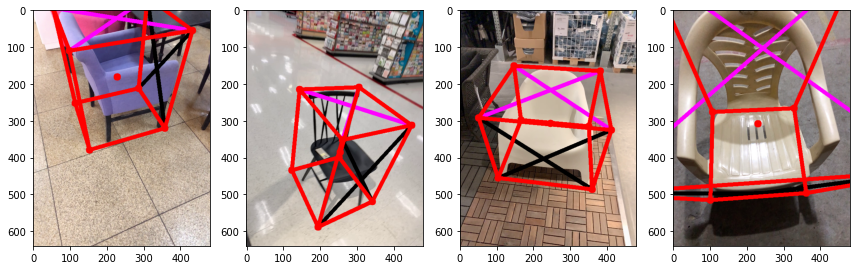

In [42]:
num_rows = 10
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

In [43]:
print('Hello World.')

Hello World.
